<a href="https://colab.research.google.com/github/someshkr/Geo-Copula/blob/main/equador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

MessageError: ignored

In [2]:
!pip install geopy
!pip install geopandas
!pip install shapely
!pip install fiona
!pip install pyproj 
!pip install rtree
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 27.9 MB/s 
     |████████████████████████████████| 16.7 MB 51.8 MB/s 
     |████████████████████████████████| 6.3 MB 46.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 21.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 27.3 MB/s 
  Installing bu


**Importing the libraries**

In [3]:
import tensorflow as tf
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rtree
import shapely
import fiona
import pyproj


In [14]:
# df = pd.read_excel("/content/query.xlsx")

df = pd.read_csv("/content/equador_latest.csv")

# df = pd.read_csv("/dbfs/FileStore/data/Indian_earthquake_data.csv")
df['time'] = pd.to_datetime(df['time'],utc=True)
df = df[['time','latitude','longitude','depth','mag']]
df = df.sort_values(by='time',ascending=True)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,2

,time,latitude,longitude,depth,mag
2606,1906-01-31 15:36:10+00:00,0.955,-79.369,20.0,8.80
2605,1907-06-01 08:40:37.290000+00:00,1.494,-79.952,15.0,6.62
2604,1912-07-24 11:59:18.950000+00:00,-4.896,-80.491,35.0,6.80
2603,1914-09-25 10:30:44.680000+00:00,-4.615,-80.424,35.0,6.17
2602,1914-11-18 09:38:00.190000+00:00,0.320,-81.951,15.0,6.53


In [15]:
df.shape

(2607, 5)

In [39]:
df_train = df.iloc[:2216]
df_val = df.iloc[2216:2476]
df_test = df.iloc[2476:]
df_train = df_train.set_index('time')
df_val = df_val.set_index('time')
df_test = df_test.set_index('time')

In [40]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

In [41]:
x_train.shape

(2216, 3)

In [42]:
batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

In [43]:
print("x_train shape ",x_train.shape)
print("x_test shape ",x_test.shape)
print("x_val shape ",x_val.shape)
print("y_train shape ",y_train.shape)
print("y_test shape ",y_test.shape)
print("y_val shape ",y_val.shape)
print(val_iterator)
print(test_iterator)

x_train shape  (2216, 3, 1)
x_test shape  (131, 3, 1)
x_val shape  (260, 3, 1)
y_train shape  (2216, 1)
y_test shape  (131, 1)
y_val shape  (260, 1)
<RepeatDataset element_spec=(TensorSpec(shape=(None, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


# **Bi-directional LSTM**

In [44]:
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
# Define the model
model = Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
#model.add(tf.keras.layers.Reshape((128, 1), input_shape = (128, )))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [45]:
n_steps,n_features

(3, 1)

In [46]:
# train_iterator
# X = X.reshape((X.shape[0], X.shape[1], n_features))

In [47]:
epochs = 10
steps_per_epoch = 800
validation_steps = 80
# Train with an infinite dataset
history = model.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model.summary()

Epoch 1/10
800/800 [==============================] - 8s 6ms/step - loss: 0.6129 - val_loss: 0.2187
Epoch 2/10
800/800 [==============================] - 3s 4ms/step - loss: 0.3387 - val_loss: 0.2272
Epoch 3/10
800/800 [==============================] - 4s 4ms/step - loss: 0.3344 - val_loss: 0.2463
Epoch 4/10
800/800 [==============================] - 3s 4ms/step - loss: 0.3356 - val_loss: 0.2374
Epoch 5/10
800/800 [==============================] - 4s 4ms/step - loss: 0.3343 - val_loss: 0.2242
Epoch 6/10
800/800 [==============================] - 4s 5ms/step - loss: 0.3304 - val_loss: 0.2316
Epoch 7/10
800/800 [==============================] - 4s 5ms/step - loss: 0.3324 - val_loss: 0.2300
Epoch 8/10
800/800 [==============================] - 4s 4ms/step - loss: 0.3318 - val_loss: 0.2295
Epoch 9/10
800/800 [==============================] - 4s 5ms/step - loss: 0.3336 - val_loss: 0.2465
Epoch 10/10
800/800 [==============================] - 3s 4ms/step - loss: 0.3297 - val_loss: 0.2263

In [49]:
len(model.predict(np.array(x_test)).reshape(-1))

5/5 [==============================] - 0s 3ms/step


131

In [50]:
x_test.shape

(131, 3, 1)

In [51]:
df_final = df_test.copy()
df_final['yhat']=model.predict(np.array(x_test)).reshape(-1)

5/5 [==============================] - 0s 3ms/step


# **CNN LSTM**

In [66]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

print(x_train.shape)

batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0],1, x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0],1, x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0],1, x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

print(train_iterator)



(2216, 3)
<RepeatDataset element_spec=(TensorSpec(shape=(None, 1, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [67]:
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
# Define the model
model2 = Sequential()

model2.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu',input_shape=(None,64,1))))
model2.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model2.add(TimeDistributed(Flatten()))
model2.add(LSTM(10, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

# model.fit(X, y, epochs=500, verbose=0)

In [68]:
print(n_steps,n_features)

3 1


In [69]:
epochs = 5
steps_per_epoch = 800
validation_steps = 80
# Train with an infinite dataset
history = model2.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model2.summary()

Epoch 1/5
800/800 [==============================] - 3s 2ms/step - loss: 0.4429 - val_loss: 0.2486
Epoch 2/5
800/800 [==============================] - 2s 2ms/step - loss: 0.4333 - val_loss: 0.2292
Epoch 3/5
800/800 [==============================] - 2s 2ms/step - loss: 0.4259 - val_loss: 0.3241
Epoch 4/5
800/800 [==============================] - 2s 2ms/step - loss: 0.4270 - val_loss: 0.2991
Epoch 5/5
800/800 [==============================] - 2s 2ms/step - loss: 0.4271 - val_loss: 0.2795
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 1, 3, 64)         128       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 1, 1, 64)         0         
 tributed)                                                       
                     

In [70]:
len(model2.predict(np.array(x_test)).reshape(-1))

5/5 [==============================] - 0s 3ms/step


131

In [71]:
x_test.shape

(131, 1, 3, 1)

In [72]:
df_final2 = df_test.copy()
df_final2['yhat']=model2.predict(np.array(x_test)).reshape(-1)

5/5 [==============================] - 0s 3ms/step


# **ConvLSTM**

In [73]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

print(x_train.shape)

batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0],1,1, x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0],1,1, x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0],1,1, x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

print(train_iterator)

'''
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

X = X.reshape((X.shape[0], 2, 1, x_train.shape[-2], x_train.shape[-1]))

n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
print(n_steps,n_features)

'''



(2216, 3)
<RepeatDataset element_spec=(TensorSpec(shape=(None, 1, 1, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


'\nn_features = 1\nn_seq = 2\nn_steps = 2\nX = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))\n\nX = X.reshape((X.shape[0], 2, 1, x_train.shape[-2], x_train.shape[-1]))\n\nn_steps = x_train.shape[-2]\nn_features = x_train.shape[-1]\nprint(n_steps,n_features)\n\n'

In [74]:

# define model
model3 = Sequential()
model3.add(ConvLSTM2D(filters=8, kernel_size=(1,2), activation='relu', input_shape=(1, 1,  x_train.shape[-2], x_train.shape[-1])))
model3.add(Flatten())
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=500, verbose=0)
# # demonstrate prediction
# x_input = array([60, 70, 80, 90])
# x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [75]:
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
print(n_steps,n_features)

3 1


In [76]:
epochs = 5
steps_per_epoch = 800
validation_steps = 80
# Train with an infinite dataset
history = model3.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model3.summary()

Epoch 1/5
800/800 [==============================] - 5s 3ms/step - loss: 5.7858 - val_loss: 0.2420
Epoch 2/5
800/800 [==============================] - 3s 3ms/step - loss: 0.4200 - val_loss: 0.2367
Epoch 3/5
800/800 [==============================] - 2s 3ms/step - loss: 0.4180 - val_loss: 0.2453
Epoch 4/5
800/800 [==============================] - 2s 3ms/step - loss: 0.4175 - val_loss: 0.2423
Epoch 5/5
800/800 [==============================] - 3s 3ms/step - loss: 0.4179 - val_loss: 0.2441
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 2, 8)           608       
                                                                 
 flatten_5 (Flatten)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                     

# **LSTM**

In [77]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

print(x_train.shape)

batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0],1,1, x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0],1,1, x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0],1,1, x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

print(train_iterator)


(2216, 3)
<RepeatDataset element_spec=(TensorSpec(shape=(None, 1, 1, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [78]:

# # split a univariate sequence
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 3
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# print(X.shape)
# X = X.reshape((X.shape[0], X.shape[1], n_features))
# print(X.shape)

In [79]:
# # univariate cnn lstm example
# from numpy import array
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import TimeDistributed
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D

# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 4
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# n_features = 1
# n_seq = 2
# n_steps = 2
# print(X.shape[0], n_seq, n_steps, n_features)
# print(X.shape)
# print(X)
# X = X.reshape((X.shape[0], n_seq, n_steps, n_features))


# # define model
# model = Sequential()
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(50, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# # # fit model
# # model.fit(X, y, epochs=500)
# # # demonstrate prediction
# # x_input = array([60, 70, 80, 90])
# # x_input = x_input.reshape((1, n_seq, n_steps, n_features))
# # yhat = model.predict(x_input, verbose=0)
# # print(yhat)


In [80]:
# epochs = 10
# steps_per_epoch = 800
# validation_steps = 80
# # Train with an infinite dataset
# x_train = np.array(x_train)
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# history = model.fit(x_train, y_train,epochs=epochs,
#                     steps_per_epoch=steps_per_epoch
#                    )
# print('=======================')
# model.summary()

In [81]:

#for batch_num, (x, y) in enumerate(test_iterator.take(3)):
  
len(model3.predict(np.array(x_test)).reshape(-1))

5/5 [==============================] - 0s 2ms/step


131

In [82]:

# yhat = model.predict(np.array(x_test), verbose=0).reshape(-1)


In [83]:
# x_test.shape

In [84]:
# df_final = df_test.copy()
# df_final['yhat']=model.predict(np.array(x_test)).reshape(-1)

In [85]:
df_final.head()

,latitude,longitude,depth,mag,yhat
time,,,,,
2021-06-15 14:10:01.529000+00:00,-3.9213,-76.6971,105.48,4.5,4.634818
2021-06-15 20:30:20.682000+00:00,-1.5387,-80.9059,10.00,4.9,4.435491
2021-06-16 00:32:21.221000+00:00,-1.5736,-80.7787,35.00,4.5,4.531320
2021-06-16 05:55:38.480000+00:00,-1.4485,-81.1373,10.00,4.2,4.439869
2021-06-18 17:19:45.365000+00:00,-3.8809,-81.3280,10.00,4.3,4.435005


In [86]:
# # univariate lstm example
# from numpy import array
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
 
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)
 
# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 3
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)

# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# print('++++++++++++++++++++++++++++++++++++++++++++++++')
# print(X.shape)
# X = X.reshape((X.shape[0], X.shape[1], n_features))
# print(X.ndim)
# # define model
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=200, verbose=0)
# # demonstrate prediction
# x_input = array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [87]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

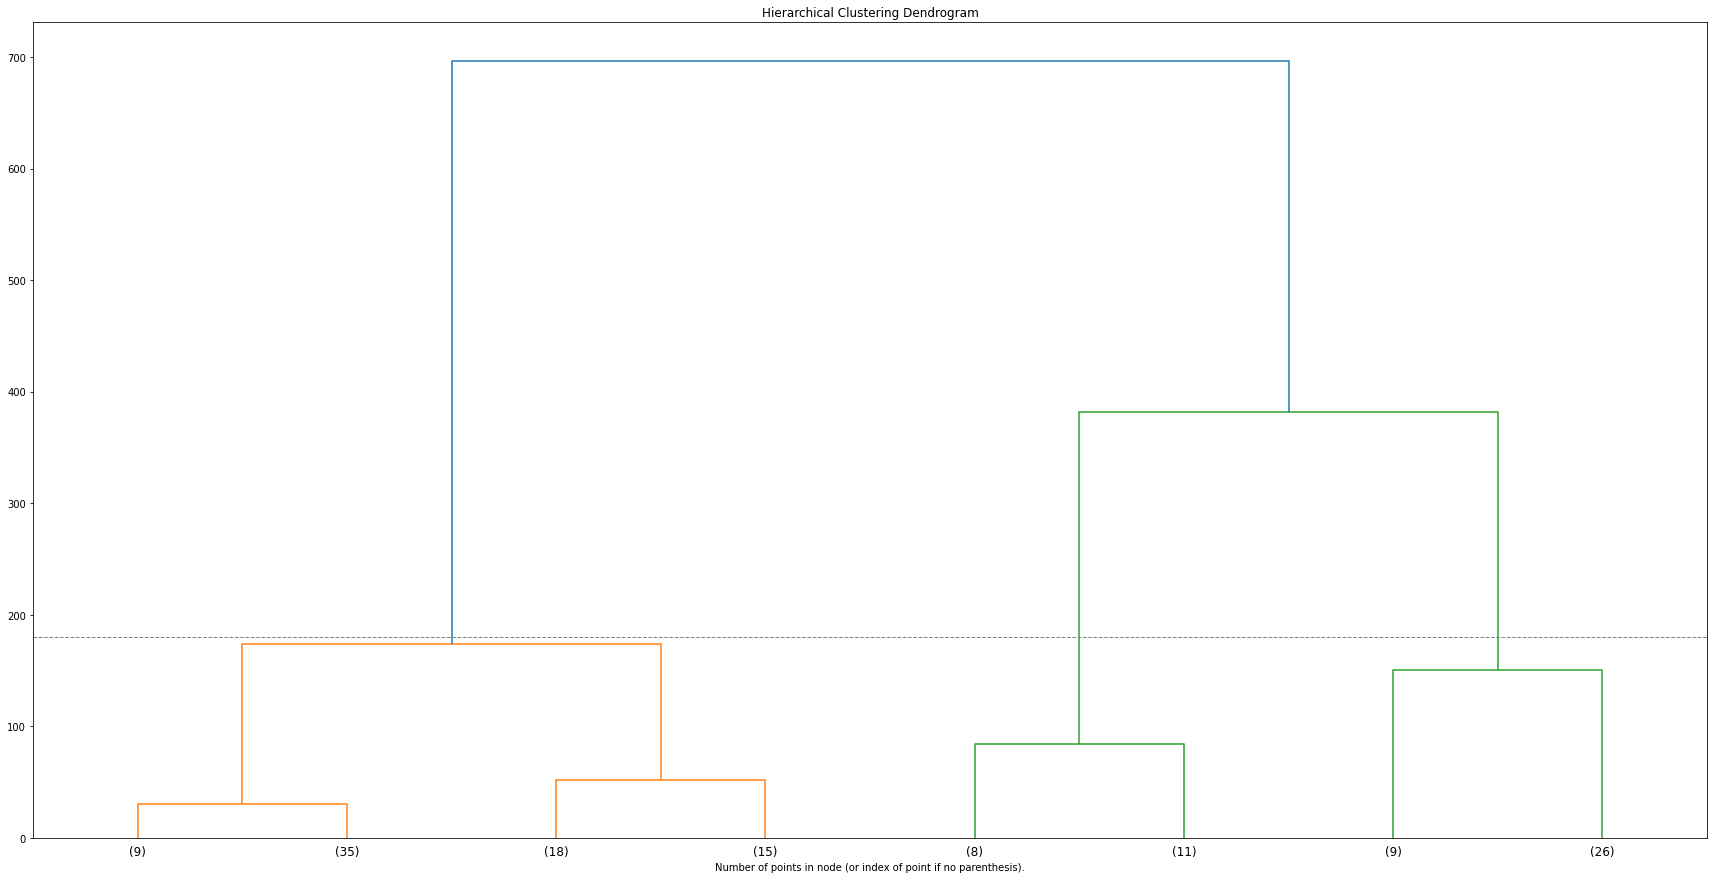

In [331]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
     
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix,**kwargs)


# iris = load_iris()
# X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
df_dend = df_final.drop(['mag'],axis=1) 
model = model.fit(df_dend)
plt.figure(figsize=(30, 15)) 
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=2)
plt.axhline(y=180,c='gray',lw=1,linestyle='dashed')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [332]:
# import scipy.cluster.hierarchy as shc
# from matplotlib import pyplot
# pyplot.figure(figsize=(30, 15))  
# pyplot.title("Dendrograms")  

# dend = shc.dendrogram(shc.linkage(df_dend, method='ward'),leaf_rotation=90,leaf_font_size=18,color_threshold=1500,truncate_mode="level")
# pyplot.axhline(y=1500,c='gray',lw=1,linestyle='dashed')
# pyplot.xlabel("data points")
# pyplot.ylabel("height")

In [333]:
cluster = AgglomerativeClustering(n_clusters=3).fit(df_dend)
df_dend['labels'] = cluster.labels_

In [91]:
df_dend.head()

,latitude,longitude,depth,yhat,labels
time,,,,,
2021-06-15 14:10:01.529000+00:00,-3.9213,-76.6971,105.48,4.634818,1
2021-06-15 20:30:20.682000+00:00,-1.5387,-80.9059,10.00,4.435491,0
2021-06-16 00:32:21.221000+00:00,-1.5736,-80.7787,35.00,4.531320,0
2021-06-16 05:55:38.480000+00:00,-1.4485,-81.1373,10.00,4.439869,0
2021-06-18 17:19:45.365000+00:00,-3.8809,-81.3280,10.00,4.435005,0


In [92]:
df_dend['labels'].unique()

array([1, 0, 2])

In [93]:
df_1 = df_dend.loc[(df_dend['labels']==0)]
df_2 = df_dend.loc[(df_dend['labels']==2)]
df_3 = df_dend.loc[(df_dend['labels']==1)]
# df_4 = df_dend.loc[(df_dend['labels']==3)]

In [94]:
df_1.head()

,latitude,longitude,depth,yhat,labels
time,,,,,
2021-06-15 20:30:20.682000+00:00,-1.5387,-80.9059,10.0,4.435491,0
2021-06-16 00:32:21.221000+00:00,-1.5736,-80.7787,35.0,4.531320,0
2021-06-16 05:55:38.480000+00:00,-1.4485,-81.1373,10.0,4.439869,0
2021-06-18 17:19:45.365000+00:00,-3.8809,-81.3280,10.0,4.435005,0
2021-07-10 16:48:32.605000+00:00,-1.1735,-80.9830,10.0,4.452945,0


# *Plotting the coordinates based on the above cluster*

In [99]:
import fsspec


# with fsspec.open("/content/data.zip") as file:
with fsspec.open("/content/data.zip") as file:
    jap = gpd.read_file(file)


# geometry = [Point(xy) for xy in zip(df_1['longitude'],df_1['latitude'])]
# gdf = GeoDataFrame(df_1,geometry=geometry)
# gdf.plot(ax=jap.plot(figsize=(25, 25)), marker='o', color='red', markersize=15);

In [100]:


gdf1 = GeoDataFrame(df_1,geometry=[Point(xy) for xy in zip(df_1['longitude'],df_1['latitude'])])
gdf2 = GeoDataFrame(df_2,geometry=[Point(xy) for xy in zip(df_2['longitude'],df_2['latitude'])])
gdf3 = GeoDataFrame(df_3,geometry=[Point(xy) for xy in zip(df_3['longitude'],df_3['latitude'])])
# gdf4 = GeoDataFrame(df_4,geometry=[Point(xy) for xy in zip(df_4['longitude'],df_4['latitude'])])

bb = gdf1[["geometry"]].copy()
bb.reset_index(level=0, inplace=True)
label_1_centroid = bb.dissolve().centroid
print(label_1_centroid)

cc = gdf2[["geometry"]].copy()
cc.reset_index(level=0, inplace=True)
label_2_centroid = cc.dissolve().centroid
print(label_2_centroid)

dd = gdf3[["geometry"]].copy()
dd.reset_index(level=0, inplace=True)
label_3_centroid = dd.dissolve().centroid
print(label_3_centroid)


# ee = gdf4[["geometry"]].copy()
# ee.reset_index(level=0, inplace=True)
# label_4_centroid = ee.dissolve().centroid
# print(label_4_centroid)

0    POINT (-80.66607 -1.35887)
dtype: geometry
0    POINT (-77.68491 -1.87134)
dtype: geometry
0    POINT (-78.57588 -3.40210)
dtype: geometry


In [101]:
print(np.concatenate((np.array(label_1_centroid.x),np.array(label_1_centroid.y)), axis=0))
print(np.concatenate((np.array(label_2_centroid.x),np.array(label_2_centroid.y)), axis=0))
print(np.concatenate((np.array(label_3_centroid.x),np.array(label_3_centroid.y)), axis=0))

[-80.66606974  -1.35887368]
[-77.68491053  -1.87134211]
[-78.57588     -3.40210286]


In [102]:
from matplotlib.patches import Circle
import cartopy
from cartopy.geodesic import Geodesic
import cartopy.crs as ccrs
import shapely.geometry as sgeom

In [103]:
X1 = np.concatenate((np.array(label_1_centroid.x),np.array(label_1_centroid.y)), axis=0)
X2 = np.concatenate((np.array(label_2_centroid.x),np.array(label_2_centroid.y)), axis=0)
print(X1,X2)

[-80.66606974  -1.35887368] [-77.68491053  -1.87134211]


In [325]:
lon = [-78.1,-77.2  ,-80.75868012]
lat = [-3.220193 ,-0.47,-0.42]



'''
middle===> top
first====> lower
last====>left
'''

'\nmiddle===> top\nfirst====> lower\nlast====>left\n'

In [326]:
pdf = pd.DataFrame({
    "centroids":["label_0","label_1","label_2"],
    "Latitude":lat,
    "Longitude":lon
})

centroid_df = gpd.GeoDataFrame(pdf, geometry=gpd.points_from_xy(pdf.Longitude, pdf.Latitude))
centroid_df

,centroids,Latitude,Longitude,geometry
0,label_0,-3.220193,-78.10000,POINT (-78.10000 -3.22019)
1,label_1,-0.470000,-77.20000,POINT (-77.20000 -0.47000)
2,label_2,-0.420000,-80.75868,POINT (-80.75868 -0.42000)


In [327]:
# verts = list(zip([-10.,10.,10.,-10],[-5.,-5.,5.,5]))
# ax.scatter([0.5,1.0],[1.0,2.0], marker=(verts,0))

In [328]:
df_dend.to_csv("final_csv.csv")

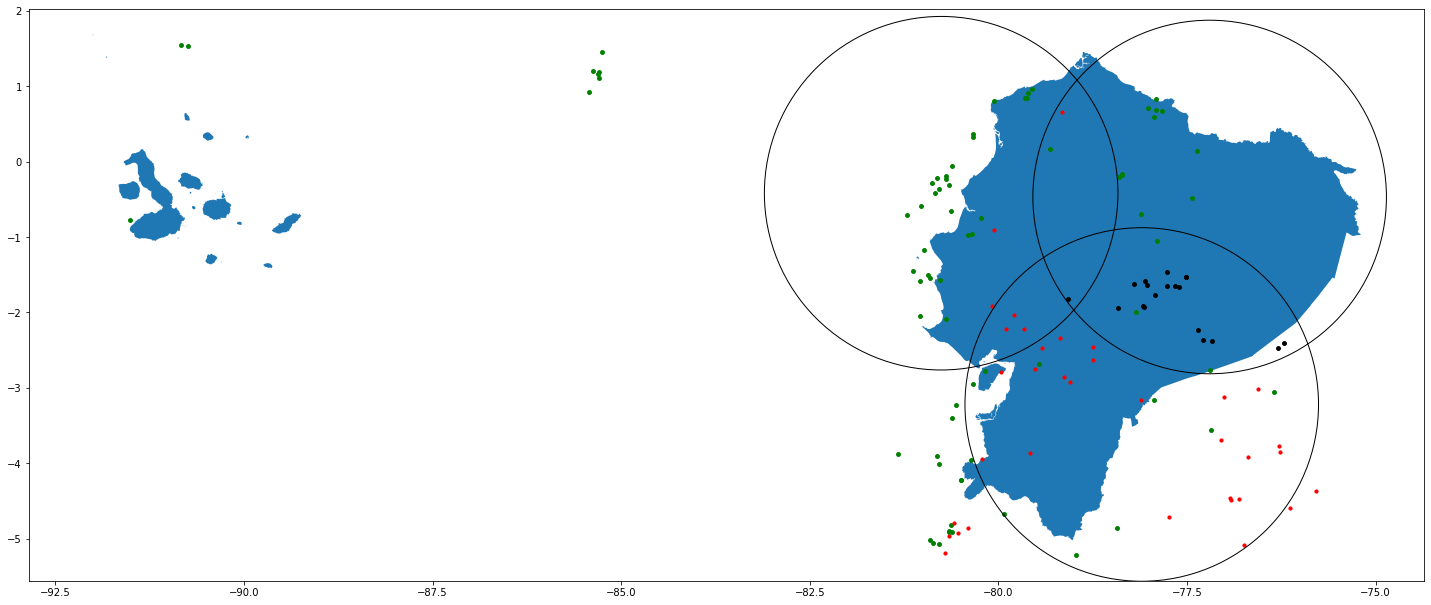

In [334]:

# gdf3 = GeoDataFrame(df_3,geometry=[Point(xy) for xy in zip(df_3['longitude'],df_3['latitude'])])
a = gdf1.plot(ax=jap.plot(figsize=(25, 25)), marker='o', color='Green', markersize=15);
b = gdf2.plot(ax=a, marker='o', color='Black', markersize=15);
c = gdf3.plot(ax=b, marker='o', color='Red', markersize=10);
# d = gdf4.plot(ax=c, marker='o', color='Yellow', markersize=5);
e = centroid_df.plot(ax=c, marker='.', color='Black', markersize=500000,facecolors='none', edgecolors="Black");
# X1 = np.concatenate((np.array(label_1_centroid.x),np.array(label_1_centroid.y)), axis=0)
# X2 = np.concatenate((np.array(label_2_centroid.x),np.array(label_2_centroid.y)), axis=0)


#fc1.plot(label_2_centroid.x,label_2_centroid.y,'black')
# c = gdf3.plot(ax=b, marker='o', color='Yellow', markersize=15);


In [319]:
# centroid_df.plot(ax=b, marker='o', color='Red', markersize=80000,facecolors='none', edgecolors="red");

In [266]:
# circle = plt.Circle((X1[0],X1[1]), 2)
# b.add_artist(circle)

In [147]:
# geometry = [Point(xy) for xy in zip(df_2['longitude'],df_2['latitude'])]
# gdf = GeoDataFrame(df_2,geometry=geometry)
# gdf.plot(ax=jap.plot(figsize=(25, 25)), marker='o', color='Green', markersize=15);

In [ ]:
# fig, gax = plt.subplots(figsize=(25,25))
# b.plot(ax=gax, color='red', alpha = 0.5)

# gax.set_xlabel('longitude')
# gax.set_ylabel('latitude')
# gax.set_title('Japan')

# gax.spines['top'].set_visible(False)
# gax.spines['right'].set_visible(False)

# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# from shapely.geometry import Polygon, Point

# # LON, LAT
# vertices = [(i,j) for i in df_1['longitude'].values for j in df_1['latitude'].values]

# p1 = Polygon(vertices)
# print(p1)
# print(p1.area)
# print(p1.bounds)
# print(p1.centroid)

# plt.plot( [v[0] for v in vertices], [v[1] for v in vertices] )
# plt.show()

In [ ]:
#https://github.com/Soroush98/LSTM-CNN_Stock/blob/master/LSTM_CNN.py